In [1]:
import numpy as np

data = np.load("./../data/collected_data.npy", allow_pickle=True)


In [2]:
import torch
print(torch.cuda.device_count())


1


In [3]:
len(data)

48

In [4]:
data[0].shape

(1000, 5)

In [5]:
data[0][0]

array([array([[ 0,  0,  0, ...,  0,  0,  0],
              [ 0,  0,  0, ...,  0,  0,  0],
              [ 0,  0,  0, ...,  0,  0,  0],
              ...,
              [ 1, 22, 16, ...,  0,  0,  0],
              [ 0,  0,  0, ...,  0,  0,  0],
              [ 0,  1,  1, ...,  0,  0,  0]], dtype=uint8),
       array([-0.7841145 ,  0.33845174,  0.4707939 ], dtype=float32),
       6.372491909385114, False, False], dtype=object)

In [6]:
# Take first episode's data
episode_data = data[0]

# Extract the states (images)
states = [x[0] for x in episode_data]

# Take some samples (e.g., first 5)
sample_states = states[0:999]


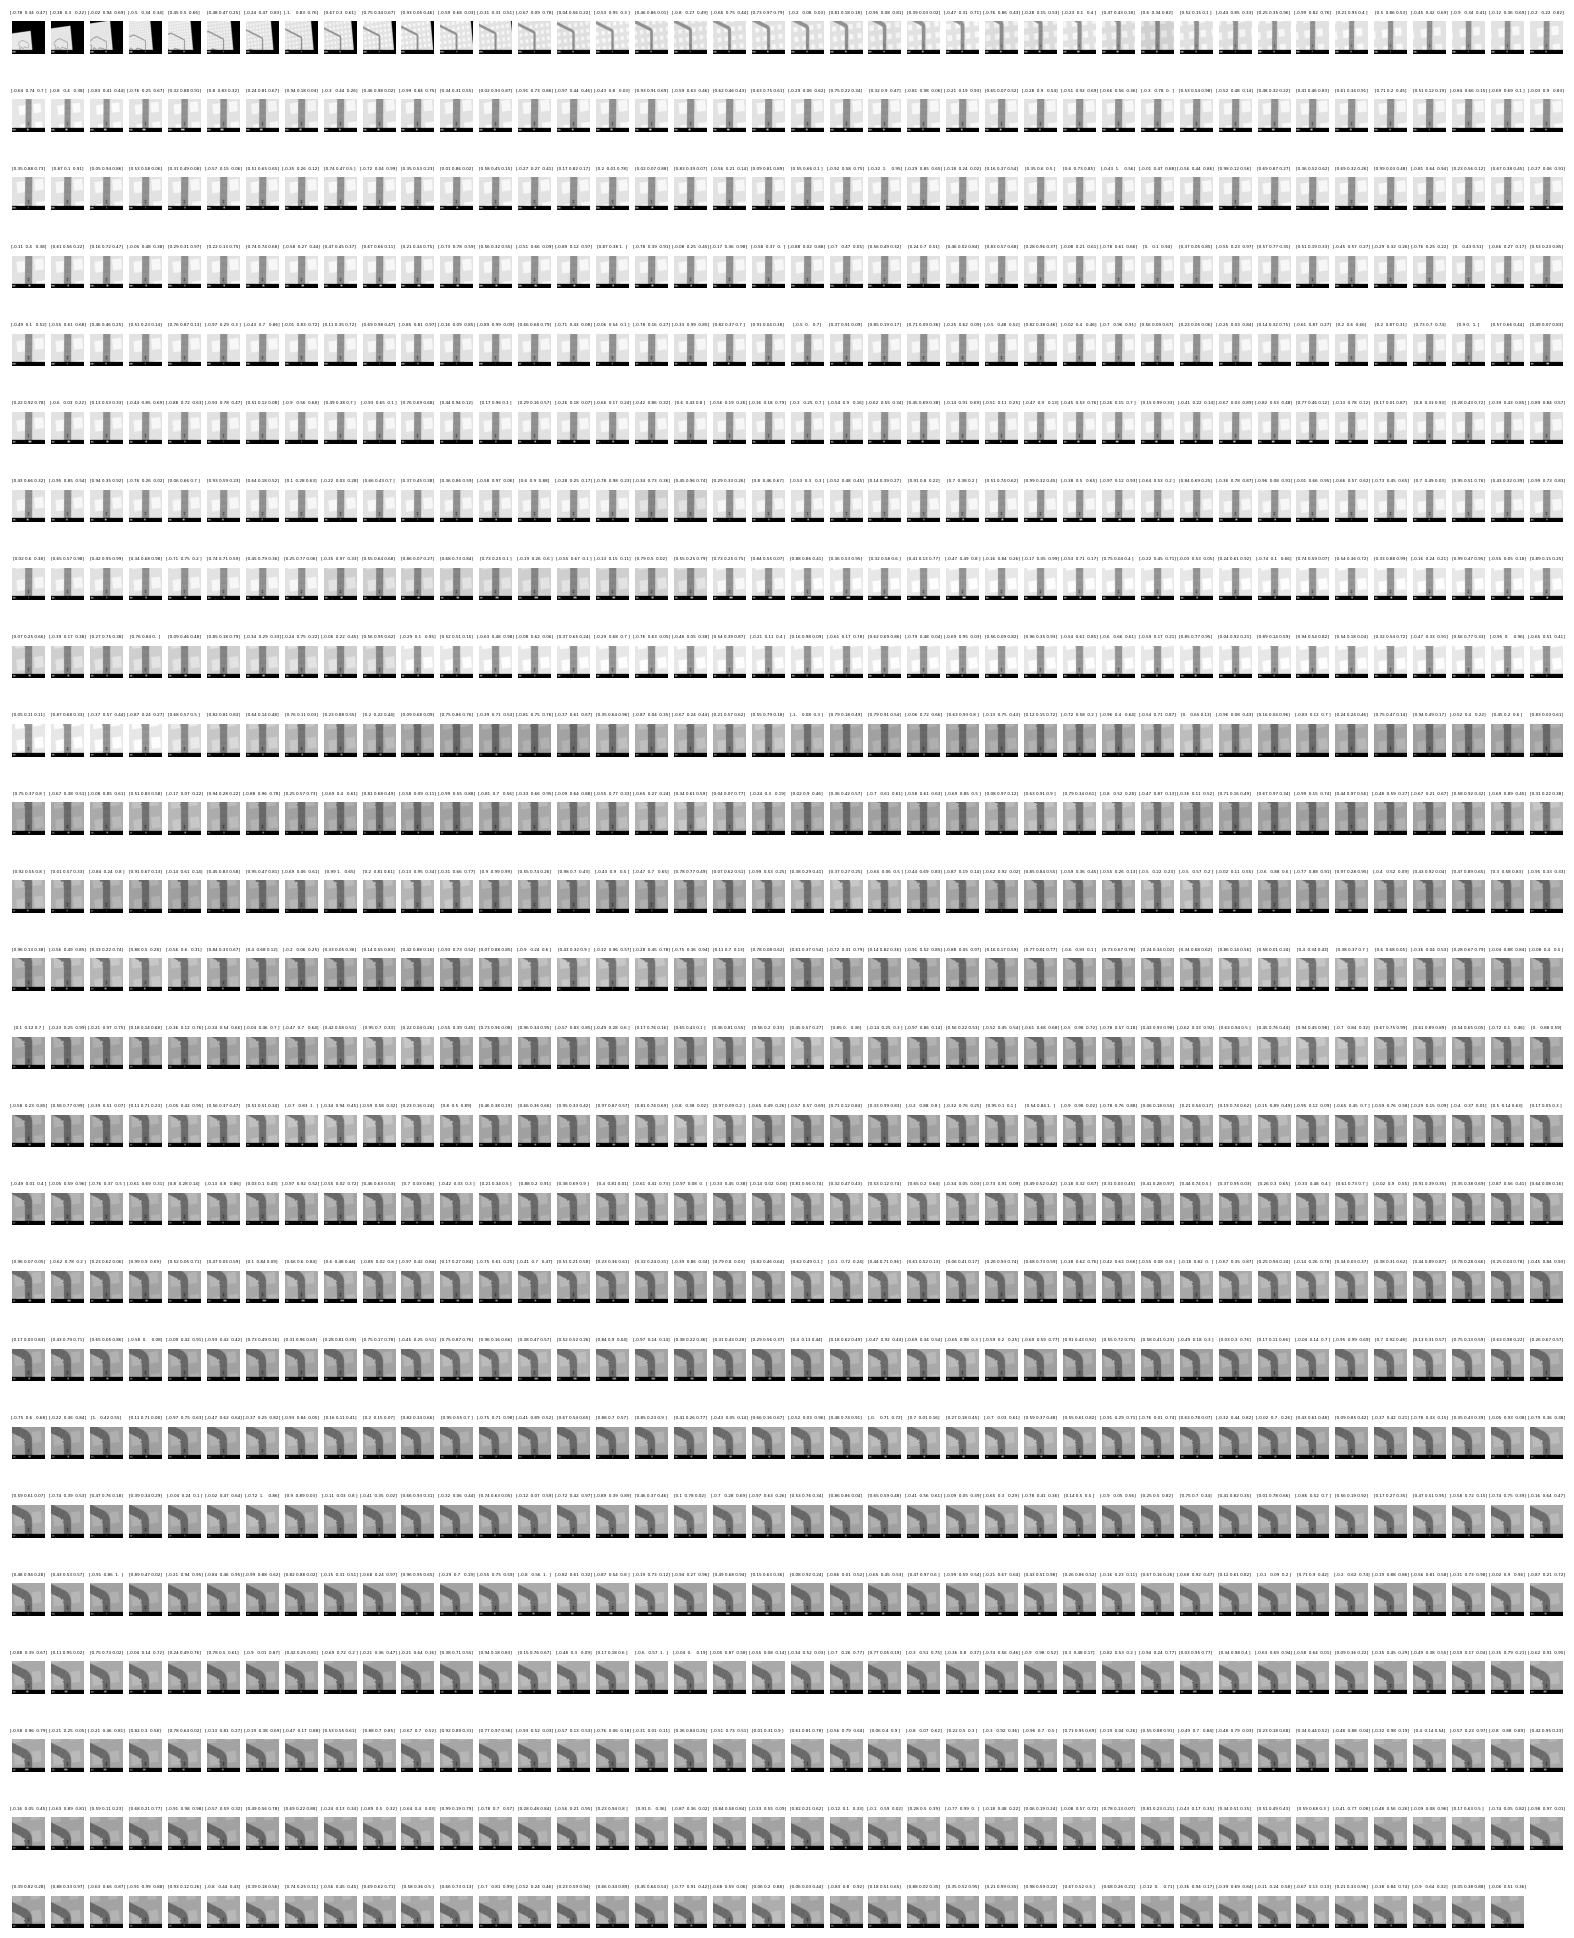

In [7]:
import matplotlib.pyplot as plt

cols = 40
for idx, image in enumerate(sample_states):
    # plot with 10 columns and number of rows based on number of samples
    plt.subplot(int(np.ceil(len(sample_states)/cols)), cols, idx+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    # add some vertical space between the images
    plt.subplots_adjust(hspace=0.6)
    # label the axes with the action
    plt.title(np.round(episode_data[idx][1],2), fontsize=3)
    #make the length of the figure relative to the number of samples
    plt.gcf().set_size_inches(20, len(sample_states)/cols)
    

plt.show()


In [8]:
import pandas as pd

flattened_data = []
episode_count = 1

for episode in data:
    for step in episode:
        # Convert step to list and prepend episode_count
        step_list = [episode_count] + list(step)
        flattened_data.append(step_list)
    episode_count += 1

df = pd.DataFrame(
    flattened_data,
    columns=["Episode", "State", "Action", "Reward", "Done", "Truncated"]
)




In [9]:
print(df.head())
print(df.describe())


   Episode                                              State  \
0        1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1        1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2        1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3,...   
3        1  [[160, 160, 160, 159, 160, 160, 159, 159, 160,...   
4        1  [[159, 163, 175, 175, 165, 159, 168, 177, 173,...   

                                  Action    Reward   Done  Truncated  
0    [-0.7841145, 0.33845174, 0.4707939]  6.372492  False      False  
1  [-0.38248476, 0.30377993, 0.21854539] -0.100000  False      False  
2  [-0.020910177, 0.93864715, 0.6903198] -0.100000  False      False  
3   [-0.49964038, 0.3411706, 0.33716467] -0.100000  False      False  
4     [0.45254418, 0.4954021, 0.6573892] -0.100000  False      False  
            Episode        Reward
count  48000.000000  48000.000000
mean      24.500000     -0.032982
std       13.853543      0.496642
min        1.000000     -0.100000
25%       12.

c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


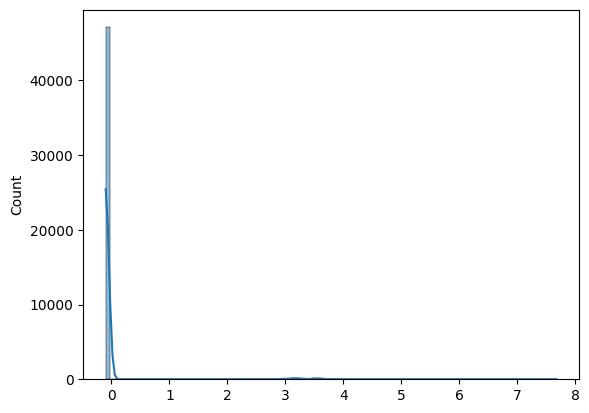

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['Reward'].values, bins=100, kde=True)
plt.show()


In [11]:
import os
print(os.getcwd())
import sys
sys.path.append("../..")


c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\notebooks


In [68]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from worldmodels1.src.worldmodels1.cnnvae import VAE

vae = VAE()
# Load the state_dict into CPU memory
state_dict = torch.load('../vae2.pth', map_location='cpu')

# Remove 'module.' prefix from state_dict keys
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the modified state_dict into the model
vae.load_state_dict(new_state_dict)
vae.eval()

VAE(
  (enc_conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc_fc1): Linear(in_features=8192, out_features=256, bias=True)
  (enc_fc2_mean): Linear(in_features=256, out_features=32, bias=True)
  (enc_fc2_logvar): Linear(in_features=256, out_features=32, bias=True)
  (dec_fc1): Linear(in_features=32, out_features=256, bias=True)
  (dec_fc2): Linear(in_features=256, out_features=8192, bias=True)
  (dec_conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec_conv1): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [69]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    vae = vae.to(device)
    print("Using GPU")

Using GPU


Episode 31 is selected


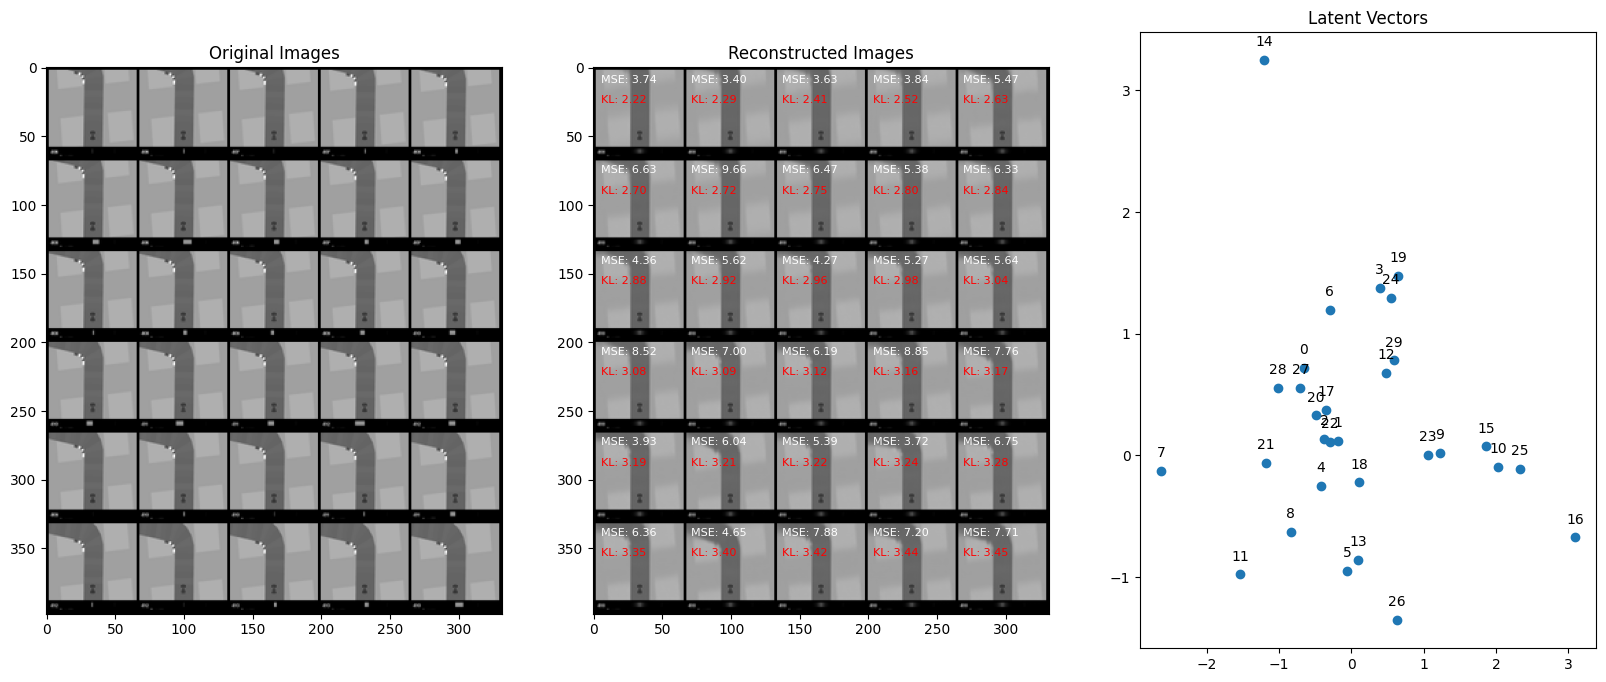

Mean Reconstruction loss: 5.92
Mean KL loss: 2.98


In [70]:
# Take the states (images) from a random episode's data
episode_idx = np.random.randint(len(data))
print(f"Episode {episode_idx} is selected")
episode_data = data[episode_idx]
states = [x[0] for x in episode_data]

# Randomly sample 30 images
#random_indices = np.random.choice(len(states), size=30, replace=False)
# take 30 sequential images
start = np.random.randint(len(states)-30)
random_indices = np.arange(start, start+30)
# take 30 sequential images skip 5 between starting at start
random_indices = np.arange(start, start+30*5, 5)
random_samples = [states[i] for i in random_indices]
random_samples = np.array(random_samples)
# Ensure random_samples has shape [batch_size, height, width]
# Add channel dimension
random_samples = np.expand_dims(random_samples, axis=1)

# Convert to PyTorch tensor and normalize to range [0, 1]
random_samples_tensor = torch.tensor(random_samples, dtype=torch.float32)/255.

# Move tensor to the appropriate device
random_samples_tensor = random_samples_tensor.to(device)

with torch.no_grad():
    reconstructed, mu, logvar = vae(random_samples_tensor)

# Convert tensors back to numpy for plotting
reconstructed = reconstructed.cpu().numpy()
mu = mu.cpu().numpy()
logvar = logvar.cpu().numpy()

# Calculate reconstruction loss (MSE) for each image
reconstruction_loss = np.sum((random_samples/255. - reconstructed)**2, axis=(1, 2, 3))
# Calculate KL divergence loss for each image
kl_loss = -0.5 * np.sum(1 + logvar - np.square(mu) - np.exp(logvar), axis=1)

plt.figure(figsize=(20, 8))

# Plotting original images
plt.subplot(1, 3, 1)
plt.title('Original Images')
grid_img = make_grid(torch.tensor(random_samples), nrow=5)
plt.imshow(np.transpose(grid_img, (1, 2, 0)))

# Plotting reconstructed images
plt.subplot(1, 3, 2)
plt.title('Reconstructed Images')
grid_img_reconstructed = make_grid(torch.tensor(reconstructed), nrow=5)
plt.imshow(np.transpose(grid_img_reconstructed, (1, 2, 0)))

# Calculate position for annotations
img_size = 64  # Assuming each image is 64x64
grid_size = 5  # 5 images in a row
padding = 2  # Default padding in make_grid

# Annotate with Reconstruction loss and KL loss
for i, (rec_loss, kl) in enumerate(zip(reconstruction_loss, kl_loss)):
    row = i // grid_size
    col = i % grid_size
    x_text = col * (img_size + padding)
    y_text = row * (img_size + padding)
    plt.text(x_text + 5, y_text + 5, f"MSE: {rec_loss:.2f}", color='white', fontsize=8, ha='left', va='top')
    plt.text(x_text + 5, y_text + 20, f"KL: {kl:.2f}", color='red', fontsize=8, ha='left', va='top')

# Plotting latent vectors
plt.subplot(1, 3, 3)
plt.title('Latent Vectors')
latent = mu + np.exp(0.5 * logvar) * np.random.randn(*logvar.shape)
scatter = plt.scatter(latent[:, 0], latent[:, 1])

# Annotate each point
for i, (x, y) in enumerate(latent[:, :2]):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Show the plot
plt.show()

# print the mean of the losses
print(f"Mean Reconstruction loss: {np.mean(reconstruction_loss):.2f}")
print(f"Mean KL loss: {np.mean(kl_loss):.2f}")


In [15]:
# Choose 10 random episodes
num_random_episodes = 10
random_episodes_indices = np.random.choice(len(data), num_random_episodes, replace=False)

# Initialize an empty list to hold states from multiple episodes
all_samples = []

# Loop through the selected random episodes to collect states
for episode_idx in random_episodes_indices:
    episode_data = data[episode_idx]
    states = [x[0] for x in episode_data]
    all_samples.extend(states)

# Convert the list to a NumPy array (assuming each state is a NumPy array)
all_samples = np.array(all_samples)
# Add channel dimension
all_samples = np.expand_dims(all_samples, axis=1)

# The shape of all_samples will be (num_samples, state_shape)
print(f"Collected a total of {len(all_samples)} states from {num_random_episodes} random episodes.")


Collected a total of 10000 states from 10 random episodes.


Text(0, 0.5, 'Latent Dim 2')

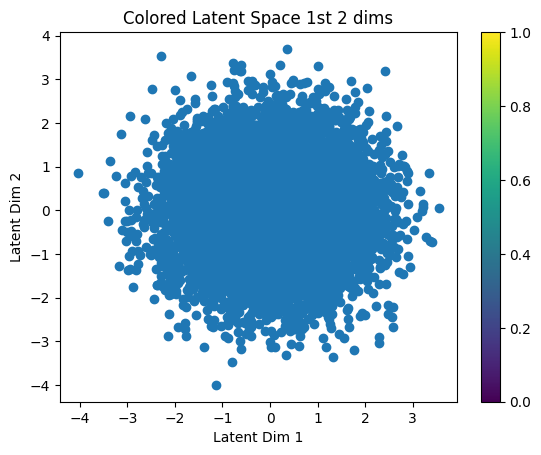

In [16]:
# Convert to PyTorch tensor and normalize to range [0, 1]
all_samples_tensor = torch.tensor(all_samples, dtype=torch.float32)/255.

# Move tensor to the appropriate device
all_samples_tensor = all_samples_tensor.to(device)

with torch.no_grad():
    _, mu, logvar = vae(all_samples_tensor)

mu = mu.cpu().numpy()
logvar = logvar.cpu().numpy()
latent = mu + np.exp(0.5 * logvar) * np.random.randn(*logvar.shape)

# Assuming `all_labels` are the corresponding labels for `all_samples`
plt.scatter(latent[:, 0], latent[:, 1])#, c=all_labels, cmap='jet')
plt.colorbar()
plt.title('Colored Latent Space 1st 2 dims')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')



In [17]:
print(latent.shape)

(10000, 32)


c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\aswegen.d\Dropbox\0_Buas\BuasDev\World Models\worldmodels1\.venv\L

Text(0.5, 1.0, 'Density Plot of Latent Space only 1st 2 dims')

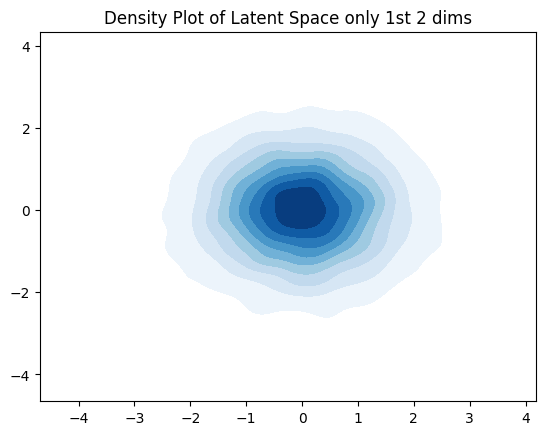

In [18]:
import seaborn as sns

sns.kdeplot(x=latent[:, 0], y=latent[:, 1], cmap="Blues", fill=True, thresh=0.05)
plt.title('Density Plot of Latent Space only 1st 2 dims')


In [ ]:
# Compute the mean and std along each dimension of the latent space
means = np.mean(latent, axis=0)
std_devs = np.std(latent, axis=0)

# Pick the two dimensions with the largest std_devs for visualization
largest_std_dims = np.argsort(std_devs)[-2:]  # Get indices of largest std devs

# Extract the values along the selected dimensions
selected_latent = latent[:, largest_std_dims]

# Create a large figure for the density plot
plt.figure(figsize=(20, 20))

# Plot the density
sns.kdeplot(x=selected_latent[:, 0], y=selected_latent[:, 1], cmap="Blues", fill=True, thresh=0.05)

# Calculate the number of images to overlay (1% in this example)
num_to_overlay = int(len(all_samples) * 0.01)
random_indices = np.random.choice(len(all_samples), num_to_overlay, replace=False)

# Choose random images and their corresponding latent coordinates
random_images = all_samples[random_indices]
random_latent_coords = selected_latent[random_indices]

# Overlay the randomly selected images
scale_factor = 0.05  # Adjust as needed
offset_x, offset_y = -1, -1  # Adjust based on your latent space

for i, img in enumerate(random_images):
    x, y = random_latent_coords[i]
    x += offset_x
    y += offset_y
    plt.imshow(img[0], extent=[x, x + scale_factor, y, y + scale_factor], cmap='gray')  # Assuming grayscale images

plt.title('Density Plot of Latent Space with Overlaid Images')
plt.show()


In [78]:
latent_dim = 32  # Replace with the actual dimension
image_height = 64  # Replace with the actual image height
image_width = 64  # Replace with the actual image width

latent_action_pairs = np.load('./../data/latent_action_pairs (6).npy')
latent_vectors = latent_action_pairs[:, :latent_dim] 
actions = latent_action_pairs[:, latent_dim:]


print(latent_action_pairs.shape)
print(latent_vectors.shape)

(10000000, 35)
(10000000, 32)


In [79]:
latent_action_pairs[0:10]

array([[-0.3171 , -0.706  ,  0.07306,  1.237  , -2.22   ,  1.886  ,
        -0.9966 ,  0.0934 ,  0.03336, -2.904  , -0.3274 , -0.0962 ,
        -0.5938 ,  0.4365 , -0.8706 , -0.2476 , -1.365  ,  0.2876 ,
        -1.023  ,  0.4172 , -0.2173 , -1.127  , -0.4644 ,  2.82   ,
         0.526  ,  1.145  , -0.836  ,  2.059  , -0.7764 , -1.028  ,
        -2.02   ,  0.851  ,  0.13   ,  0.954  ,  0.4297 ],
       [-0.069  ,  0.4004 , -0.33   , -0.2886 ,  0.04205, -1.363  ,
        -0.595  ,  0.499  ,  1.089  , -3.178  ,  0.512  ,  0.8374 ,
         1.591  ,  0.2854 ,  0.1395 ,  0.4163 ,  1.697  ,  1.674  ,
         1.45   ,  1.329  ,  1.022  ,  1.088  ,  2.455  ,  1.124  ,
         0.9536 , -0.4192 ,  0.546  ,  0.1686 , -0.7593 , -1.515  ,
         0.9004 , -0.265  ,  0.2393 ,  0.2693 ,  0.3623 ],
       [ 0.6567 , -1.155  , -0.675  , -0.161  ,  0.8765 ,  0.9507 ,
         0.0547 ,  1.34   , -1.499  , -2.99   , -0.737  , -1.316  ,
         0.7017 , -0.2693 , -1.525  ,  1.114  , -0.4443 ,  0.966  

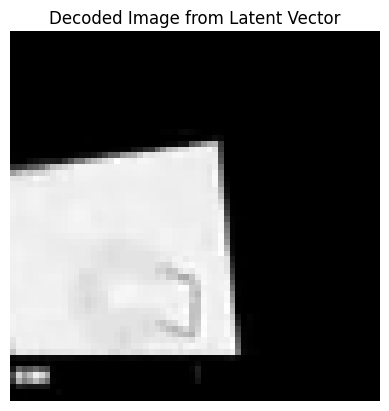

In [80]:
# Take one latent vector
latent_vector = torch.tensor(latent_vectors[0], dtype=torch.float32).unsqueeze(0).to(device)

# Decode the latent vector
with torch.no_grad():
    decoded_img = vae.decode(latent_vector).squeeze().cpu().numpy()

# If your decoded image is not in the shape you expect, reshape it accordingly
decoded_img = decoded_img.reshape((image_height, image_width))  # Assuming grayscale images

plt.imshow(decoded_img, cmap='gray')  # or cmap='color' if your image is color
plt.title('Decoded Image from Latent Vector')
plt.axis('off')
plt.show()


interactive(children=(IntSlider(value=499, description='idx', max=999), Output()), _dom_classes=('widget-inter…

<function __main__.decode_and_plot(idx)>

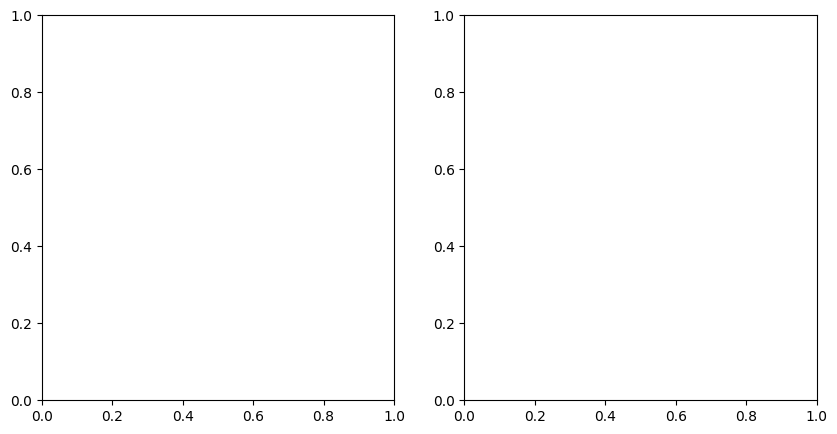

In [87]:
from ipywidgets import interact

def decode_and_plot(idx):
    latent_vector = torch.tensor(latent_vectors[idx], dtype=torch.float32).unsqueeze(0).to(device)
    
    # Decode the latent vector
    with torch.no_grad():
        decoded_img = vae.decode(latent_vector).squeeze().cpu().numpy()
    
    decoded_img = decoded_img.reshape((image_height, image_width))
    
    # Create a subplot for original and decoded images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot the original image
    axes[0].imshow(sample_states[idx], cmap='gray')
    axes[0].set_title(f'Original Image (Index {idx})')
    axes[0].axis('off')
    
    # Plot the decoded image
    axes[1].imshow(decoded_img, cmap='gray')
    axes[1].set_title(f'Decoded Image (Index {idx})')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Create a slider to select the latent vector index
interact(decode_and_plot, idx=(0, len(sample_states) - 1))



# LATENTS ARE SHUFFLED NEED TO FIX - This is fixed there was not shuffle the first VAE model was bad.


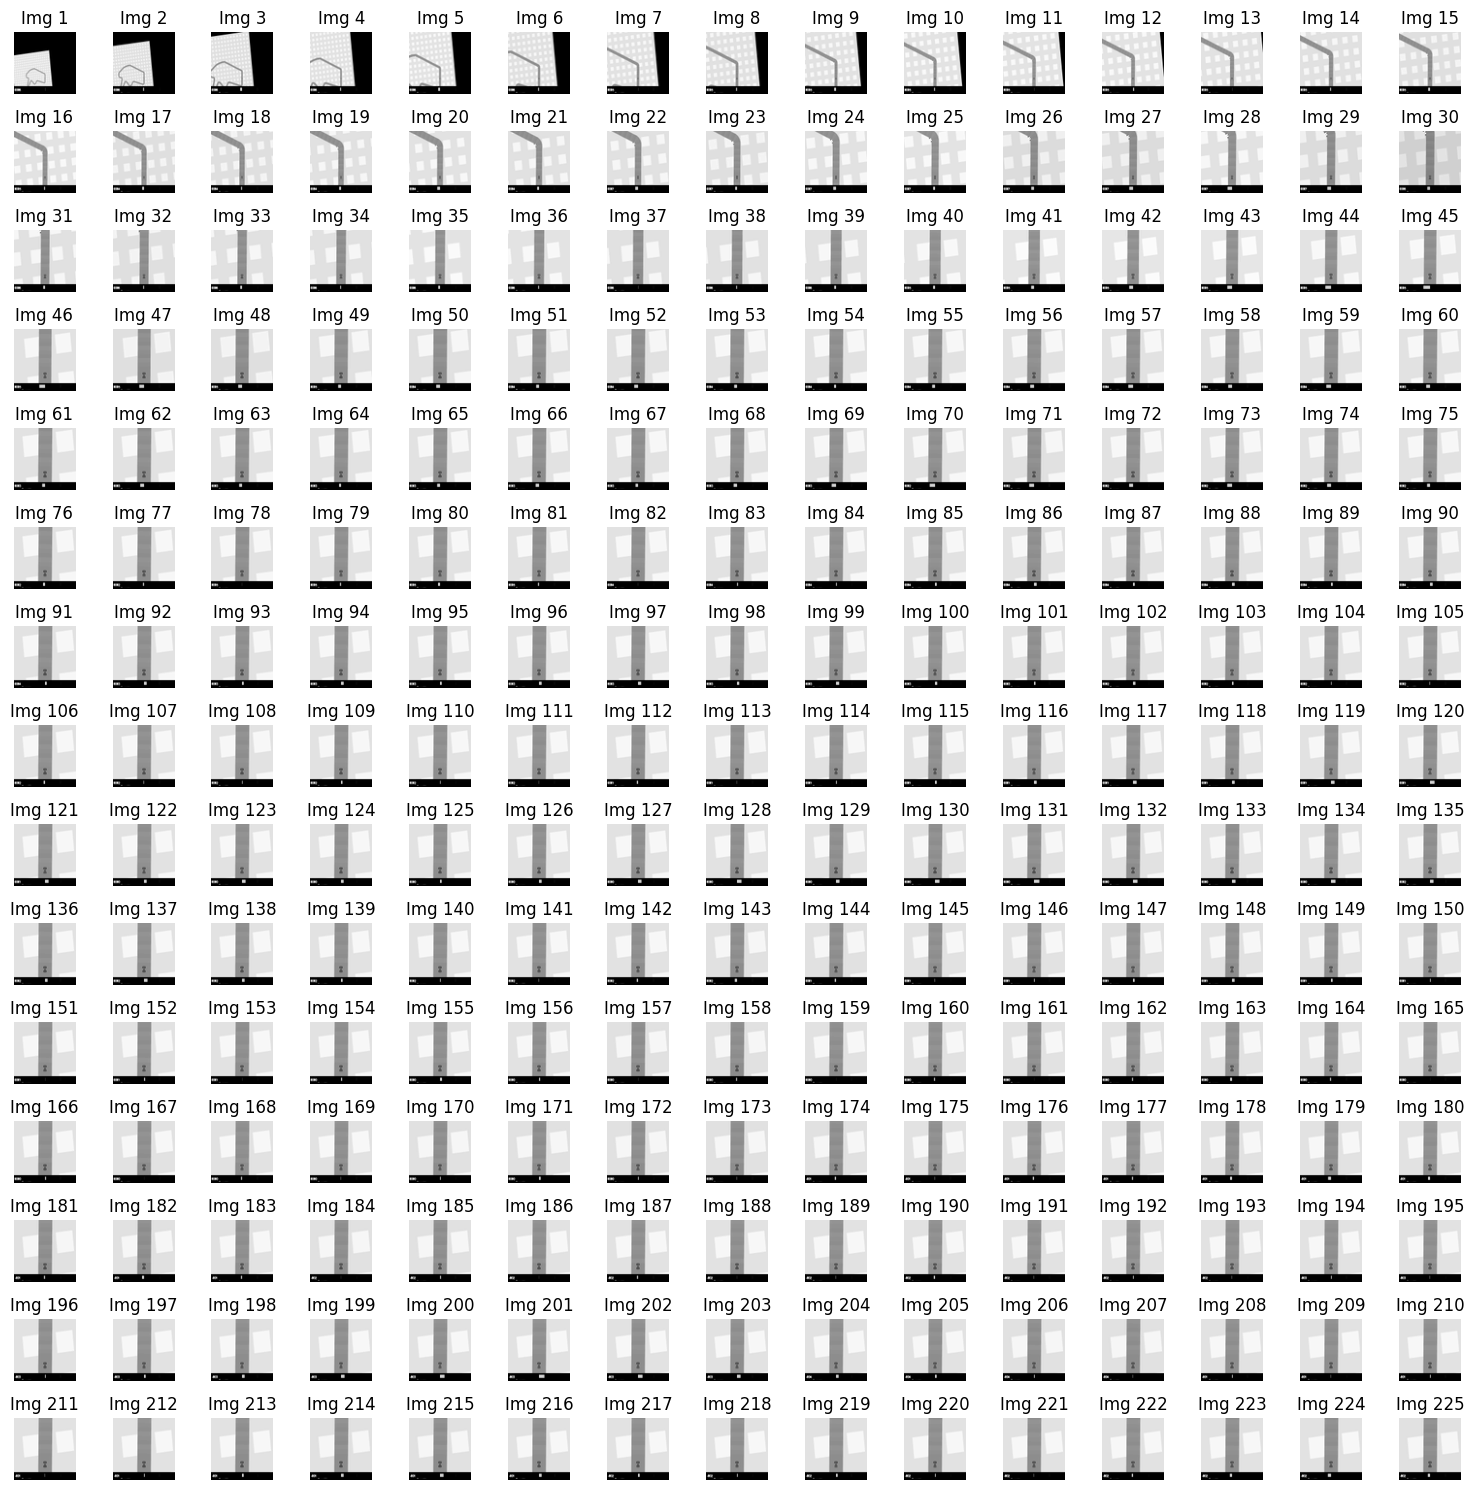

In [83]:
# Create a 10x10 grid for plotting
fig, axes = plt.subplots(15, 15, figsize=(15, 15))

# Flatten the 10x10 grid into a list for easy iteration
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    #Plot original image in original position
    
    
    ax.imshow(sample_states[i], cmap='gray')
    ax.set_title(f'Img {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

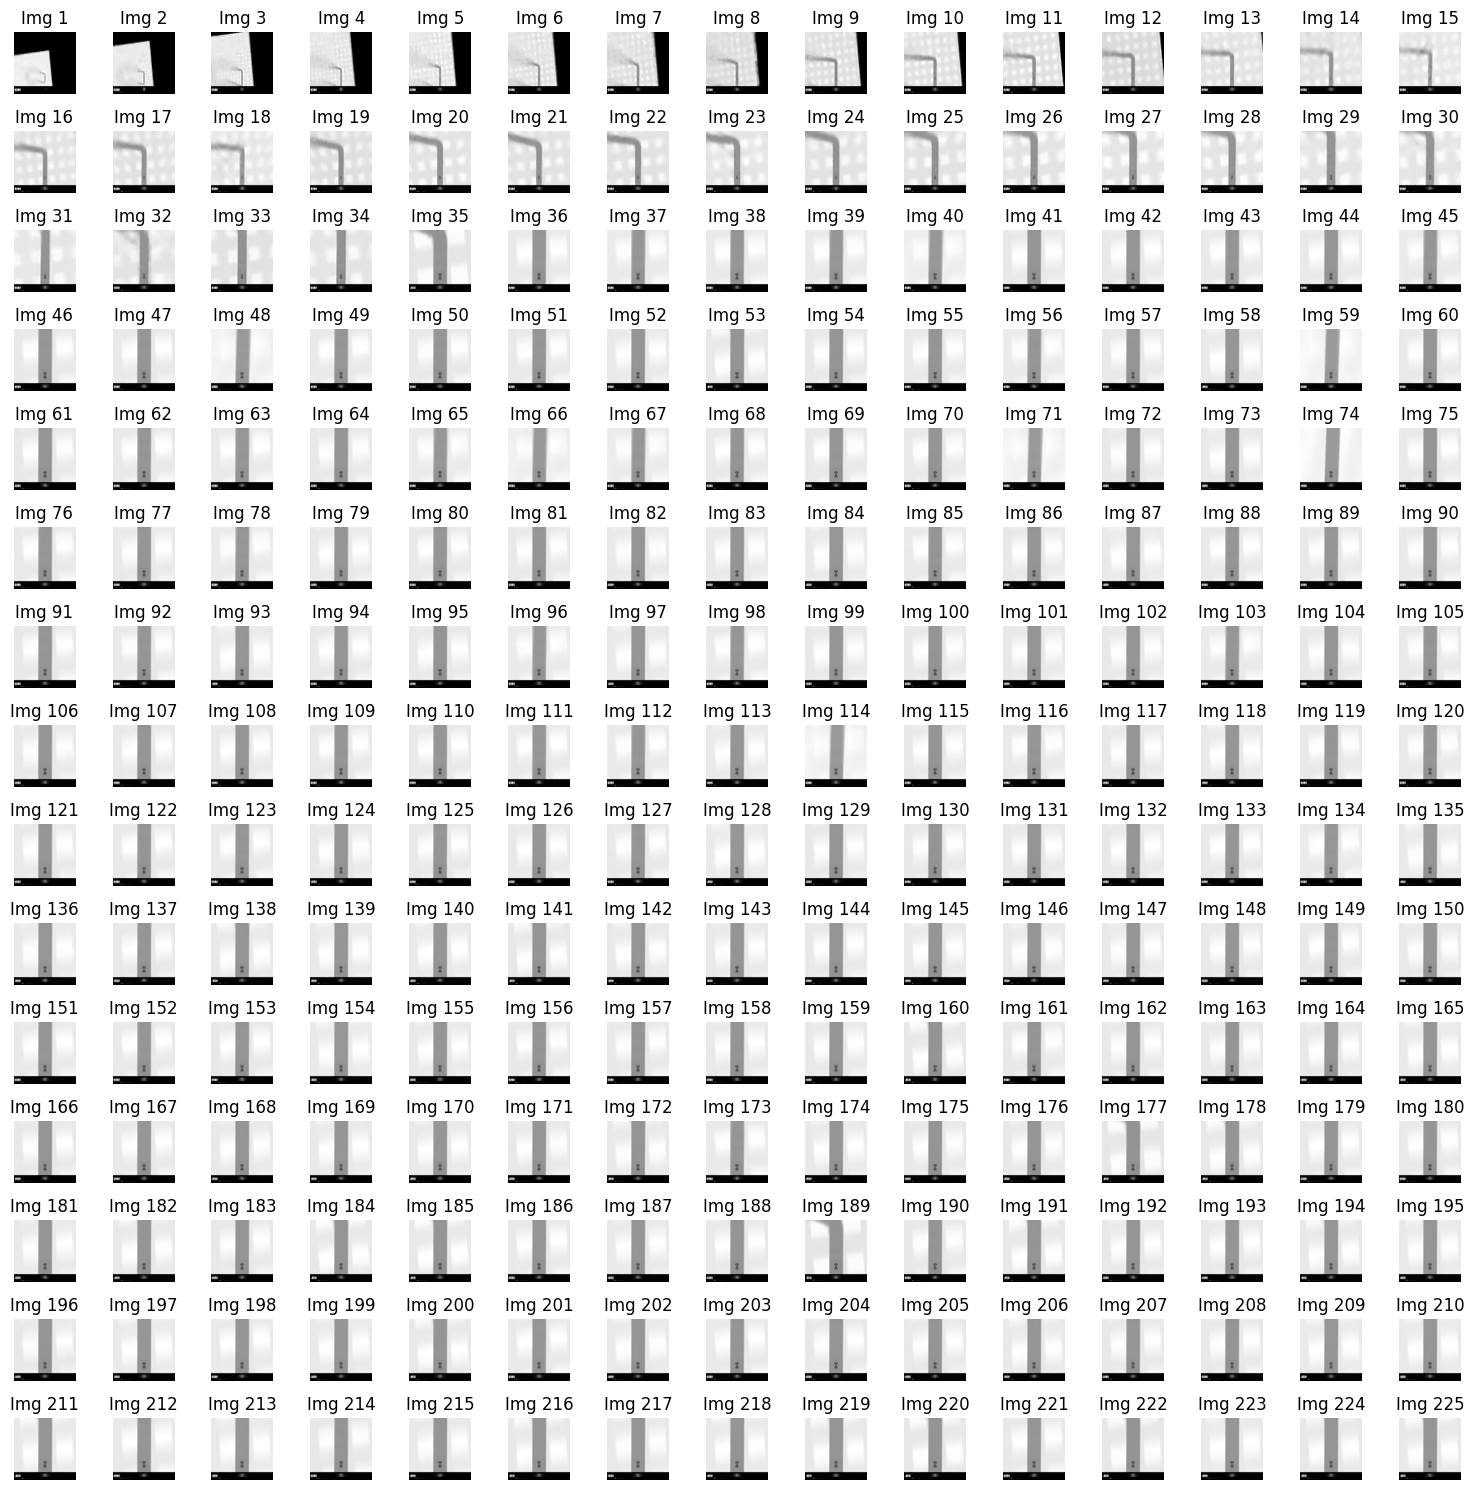

In [84]:
# Create a 10x10 grid for plotting
fig, axes = plt.subplots(15, 15, figsize=(15, 15))

# Flatten the 10x10 grid into a list for easy iteration
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    latent_vector = torch.tensor(latent_vectors[i], dtype=torch.float32).unsqueeze(0).to(device)
    
    # Decode the latent vector
    with torch.no_grad():
        decoded_img = vae.decode(latent_vector).squeeze().cpu().numpy()

    # If your decoded image is not in the shape you expect, reshape it
    decoded_img = decoded_img.reshape((image_height, image_width))  # Replace with your actual image dimensions
    
    ax.imshow(decoded_img, cmap='gray')  # or cmap='color' if your image is color
    ax.set_title(f'Img {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()
